# Fit a linear model on cell morphology features

Our aim is to determine which features significantly contribute to NF1 genotype adjusted by cell count

In [1]:
import pathlib
import pandas as pd

from sklearn.linear_model import LinearRegression

from pycytominer.cyto_utils import infer_cp_features

In [2]:
# Define inputs and outputs
data_dir = pathlib.Path("..", "..", "..", "4_processing_features", "data", "Plate2")
cp_file = pathlib.Path(data_dir, "CellProfiler", "nf1_sc_norm_cellprofiler_plate2.csv.gz")
dp_file = pathlib.Path(data_dir, "DeepProfiler", "nf1_sc_norm_fs_deepprofiler_cyto.csv.gz")

output_dir = pathlib.Path("results/Plate2")
output_cp_file = pathlib.Path(output_dir, "linear_model_all_cp_features.tsv")
output_dp_file = pathlib.Path(output_dir, "linear_model_dp_features.tsv")

## CellProfiler features

In [3]:
# Load data
cp_df = pd.read_csv(cp_file, index_col=0)

# Define CellProfiler features
cp_features = infer_cp_features(cp_df)

print(f"We are testing {len(cp_features)} CellProfiler features")
print(cp_df.shape)
cp_df.head()

We are testing 1198 CellProfiler features
(1681, 1210)


,Metadata_WellRow,Metadata_WellCol,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,A,1,47,NF1,WT,5,1,A1,1,5,...,-0.495350,-0.514045,-0.555610,-0.559995,-0.548735,-0.555726,-0.348458,-0.340556,-0.350308,-0.346040
1,A,1,47,NF1,WT,5,1,A1,2,6,...,-0.364010,-0.355870,-0.526935,-0.519503,-0.520462,-0.521410,-0.326066,-0.321458,-0.328143,-0.322053
2,A,1,47,NF1,WT,5,1,A1,3,7,...,-0.560737,-0.562072,-0.587002,-0.581442,-0.586415,-0.586955,-0.257219,-0.258769,-0.262309,-0.248892
3,A,1,47,NF1,WT,5,1,A1,4,8,...,-0.544709,-0.555251,-0.534545,-0.536454,-0.544085,-0.538894,-0.255221,-0.244431,-0.250231,-0.251954
4,A,1,47,NF1,WT,5,1,A1,5,9,...,-0.543428,-0.545198,-0.540300,-0.533981,-0.531080,-0.531899,-0.280850,-0.284476,-0.285872,-0.275760


## Fit linear model

In [4]:
# Setup linear modeling framework
variables = ["Metadata_number_of_singlecells"]
X = cp_df.loc[:, variables]

# Add dummy matrix of categorical genotypes
genotype_x = pd.get_dummies(data=cp_df.Metadata_genotype)

X = pd.concat([X, genotype_x], axis=1)

print(X.shape)
X.head()

(1681, 3)


,Metadata_number_of_singlecells,Null,WT
0,47,0,1
1,47,0,1
2,47,0,1
3,47,0,1
4,47,0,1


In [5]:
# Fit linear model for each feature
lm_results = []
for cp_feature in cp_features:
    # Subset CP data to each individual feature (univariate test)
    cp_subset_df = cp_df.loc[:, cp_feature]

    # Fit linear model
    lm = LinearRegression(fit_intercept=True)
    lm_result = lm.fit(X=X, y=cp_subset_df)
    
    # Extract Beta coefficients
    # (contribution of feature to X covariates)
    coef = lm_result.coef_
    
    # Estimate fit (R^2)
    r2_score = lm.score(X=X, y=cp_subset_df)
    
    # Add results to a growing list
    lm_results.append([cp_feature, r2_score] + list(coef))

# Convert results to a pandas DataFrame
lm_results = pd.DataFrame(
    lm_results,
    columns=["feature", "r2_score", "cell_count_coef", "Null_coef", "WT_coef"]
)

# Output file
lm_results.to_csv(output_cp_file, sep="\t", index=False)

print(lm_results.shape)
lm_results.head()

(1198, 5)


,feature,r2_score,cell_count_coef,Null_coef,WT_coef
0,Cytoplasm_Number_Object_Number,0.129892,0.023627,0.010305,-0.010305
1,Cytoplasm_AreaShape_Area,0.227782,-0.013079,-0.332435,0.332435
2,Cytoplasm_AreaShape_BoundingBoxArea,0.171188,-0.016135,-0.218082,0.218082
3,Cytoplasm_AreaShape_BoundingBoxMaximum_X,0.001246,0.000430,-0.039782,0.039782
4,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,0.003629,0.001267,-0.071914,0.071914


/home/jenna/anaconda3/envs/5.analyze_data_NF1/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='cell_count_coef', ylabel='WT_coef'>

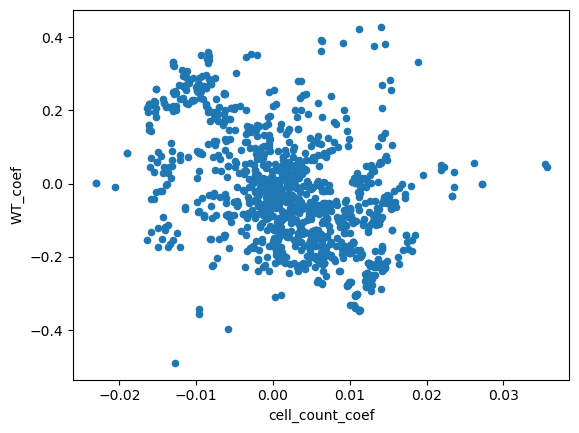

In [6]:
# Small exploration visualization
lm_results.plot(x="cell_count_coef", y="WT_coef", kind="scatter")

## DeepProfiler features

In [7]:
# Load data
dp_df = pd.read_csv(dp_file)

# Define CellProfiler features
dp_features = dp_df.columns[dp_df.columns.str.startswith("efficientnet")]

print(f"We are testing {len(dp_features)} DeepProfiler features")
print(dp_df.shape)
dp_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../../4_processing_features/data/Plate2/DeepProfiler/nf1_sc_norm_fs_deepprofiler_cyto.csv.gz'

In [ ]:
# Merge number of single cells per well data
cell_count_df = (
    dp_df
    .groupby("Metadata_Well")["Metadata_Plate"]
    .count()
    .reset_index()
    .rename(columns={"Metadata_Plate": "Metadata_number_of_singlecells"})
)

dp_df = dp_df.merge(cell_count_df, on="Metadata_Well")

In [ ]:
# Setup linear modeling framework
variables = ["Metadata_number_of_singlecells"]
X = dp_df.loc[:, variables]

# Add dummy matrix of categorical genotypes
genotype_x = pd.get_dummies(data=dp_df.Metadata_Genotype)

X = pd.concat([X, genotype_x], axis=1)

print(X.shape)
X.head()

In [ ]:
# Fit linear model for each feature
lm_results = []
for dp_feature in dp_features:
    # Subset DP data to each individual feature (univariate test)
    dp_subset_df = dp_df.loc[:, dp_feature]

    # Fit linear model
    lm = LinearRegression(fit_intercept=True)
    lm_result = lm.fit(X=X, y=dp_subset_df)
    
    # Extract Beta coefficients
    # (contribution of feature to X covariates)
    coef = lm_result.coef_
    
    # Estimate fit (R^2)
    r2_score = lm.score(X=X, y=dp_subset_df)
    
    # Add results to a growing list
    lm_results.append([dp_feature, r2_score] + list(coef))

# Convert results to a pandas DataFrame
lm_results = pd.DataFrame(
    lm_results,
    columns=["feature", "r2_score", "cell_count_coef", "Null_coef", "WT_coef"]
)

# Output file
lm_results.to_csv(output_dp_file, sep="\t", index=False)

print(lm_results.shape)
lm_results.head()

In [ ]:
# Small exploration visualization
lm_results.plot(x="cell_count_coef", y="WT_coef", kind="scatter")